# Computer Vision and Advanced Machine Learning area of the project.
### Author: Hugo Iglesias Pombo (2025)
### NO2.1: EDA and preprocessing of the datasets and Attention U-Net architecture with Genetic Algorithms for hyperparameter optimization.

##### This notebook implements an attention-based U-Net architecture for segmenting breast cancer lesions in ultrasound images. The attention mechanism helps the model focus on relevant areas, improving segmentation accuracy in challenging medical imaging scenarios.

In this notebook, I implement a modified version of the U-Net architecture incorporating an attention
mechanism specifically designed for breast cancer segmentation in ultrasound images. By enhancing the
network with attention gates, the model can selectively focus on relevant regions while suppressing
irrelevant background features. This is particularly valuable for medical imaging tasks where
target structures occupy only a small portion of the input image and are often accompanied by noisy
surroundings.

First, I'll import the necessary libraries for data processing, model implementation, and visualization.
I also set up device configuration to utilize GPU acceleration when available, with specific support
for Apple Silicon's MPS backend.

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import random

import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch
import torch.optim as optim
from torch.utils.data import Dataset
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F

import warnings
warnings.filterwarnings("ignore")

import glob

from sklearn.model_selection import train_test_split

# Ajuste para usar MPS en MacBook Pro M4 Pro
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Usando MPS (GPU de Apple)")
elif torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Usando CUDA")
else:
    device = torch.device("cpu")
    print("Usando CPU")

# Carga de imágenes - ajusta la ruta según donde estén tus datos
masks = glob.glob("/Volumes/Proyecto_Hugo/breast-cancer-analysis/datasets/Dataset_BUSI_with_GT/*/*_mask.png")
images = [mask_images.replace("_mask", "") for mask_images in masks]
series = list(zip(images, masks))

Usando MPS (GPU de Apple)


In [15]:
# Data Visualization Function

# Función de visualización del dataset original
def plot_train_label(image_mask):
    image = cv2.imread(image_mask[0])
    mask = cv2.imread(image_mask[1])
    
    f, axarr = plt.subplots(1, 3, figsize=(5, 5))
    
    axarr[0].imshow(np.squeeze(image), cmap='gray', origin='lower')
    axarr[0].set_ylabel('Axial View', fontsize=14)
    axarr[0].set_xticks([])
    axarr[0].set_yticks([])
    axarr[0].set_title('CT', fontsize=14)

    axarr[1].imshow(np.squeeze(mask), cmap='jet', origin='lower')
    axarr[1].axis('off')
    axarr[1].set_title('Mask', fontsize=14)

    axarr[2].imshow(np.squeeze(image), cmap='gray', alpha=1, origin='lower')
    axarr[2].imshow(np.squeeze(mask), cmap='jet', alpha=0.5, origin='lower')
    axarr[2].axis('off')
    axarr[2].set_title('Overlay', fontsize=14)

    plt.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

In [16]:
# Dataset Preparation and Splitting

# Dataset y particiones
dataset = pd.DataFrame(series, columns=['image_path', 'mask_path'])
train, test = train_test_split(dataset, test_size=0.25)

print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")

Train shape: (585, 2)
Test shape: (195, 2)


In [17]:
# Custom Dataset Implementation

# Dataset personalizado (igual que el original)
class CustomImageMaskDataset(Dataset):
    np.random.seed(42)
    torch.manual_seed(42)
    def __init__(self, dataframe, image_transform=None):
        self.data = dataframe
        self.image_transform = image_transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = self.data.iloc[idx]['image_path']
        mask_path = self.data.iloc[idx]['mask_path']

        image = Image.open(image_path).convert('L') 
        mask = Image.open(mask_path).convert('L')

        if self.image_transform:
            image = self.image_transform(image)
            mask = self.image_transform(mask)

        return image, mask

In [18]:
# Data Transformation Pipeline with Data Augmentation

# Transformaciones mejoradas con data augmentation básica
image_size = 128
    
train_transforms = transforms.Compose([
    transforms.Resize([image_size, image_size]),
    transforms.RandomHorizontalFlip(p=0.5),   # Añadido: volteo horizontal
    transforms.RandomRotation(10),            # Añadido: rotación leve
    transforms.ToTensor(),
])

val_transforms = transforms.Compose([
    transforms.Resize([image_size, image_size]),
    transforms.ToTensor(),
])

# Crear datasets
train_dataset = CustomImageMaskDataset(train, train_transforms)
test_dataset = CustomImageMaskDataset(test, val_transforms)

In [19]:
# DataLoader Configuration

# DataLoaders
batch_size = 16  # Mantenemos el batch size original
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [20]:
# Tensor to NumPy Conversion Utility

def to_numpy(tensor):
    # Manejo para MPS (Apple Silicon)
    if tensor.device.type == 'mps':
        return tensor.detach().cpu().numpy()
    return tensor.cpu().detach().numpy()

In [21]:
# Convolutional Block Implementation

# Bloque convolucional (igual que el original)
class ConvBlock(nn.Module):
    def __init__(self, input_channel, out_channel, dropout):
        super(ConvBlock, self).__init__()
        self.conv2d_1 = nn.Conv2d(input_channel, out_channel, kernel_size=3, padding=1)
        self.batchnorm_1 = nn.BatchNorm2d(out_channel)
        self.relu_1 = nn.ReLU()
        
        self.dropout = nn.Dropout(dropout)
        
        self.conv2d_2 = nn.Conv2d(out_channel, out_channel, kernel_size=3, padding=1)
        self.batchnorm_2 = nn.BatchNorm2d(out_channel)
        self.relu_2 = nn.ReLU()

    def forward(self, x):
        x = self.conv2d_1(x)
        x = self.batchnorm_1(x)
        x = self.relu_1(x)
        
        x = self.dropout(x)
        
        x = self.conv2d_2(x)
        x = self.batchnorm_2(x)
        x = self.relu_2(x)

        return x

In [22]:
# Encoder Block Implementation

# Encoder (igual que el original)
class Encoder(nn.Module):
    def __init__(self, input_channel, out_channel, dropout):
        super(Encoder, self).__init__()
        self.conv2d_1 = ConvBlock(input_channel, out_channel, dropout)
        self.maxpool = nn.MaxPool2d((2,2))
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        x = self.conv2d_1(x)
        p = self.maxpool(x)
        p = self.dropout(p)

        return x, p

In [23]:
# Attention Mechanism Implementation

# Mecanismo de atención simple
class SimpleAttention(nn.Module):
    def __init__(self, in_channels):
        super(SimpleAttention, self).__init__()
        self.conv = nn.Conv2d(in_channels, 1, kernel_size=1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # Generar mapa de atención
        attn = self.conv(x)
        attn = self.sigmoid(attn)
        
        # Aplicar atención a la entrada
        return x * attn

In [24]:
# Decoder Block with Attention Implementation

# Decoder (igual que el original pero con atención)
class Decoder(nn.Module):
    def __init__(self, input_channel, output_channel, dropout):
        super(Decoder, self).__init__()
        self.conv_t = nn.ConvTranspose2d(input_channel, output_channel, stride=2, kernel_size=2)
        
        # Agregar mecanismo de atención simple
        self.attention = SimpleAttention(output_channel)
        
        self.conv2d_1 = ConvBlock(output_channel*2, output_channel, dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, skip):
        x = self.conv_t(x)
        
        # Aplicar mecanismo de atención al skip connection
        skip_with_attention = self.attention(skip)
        
        x = torch.cat([x, skip_with_attention], dim=1)
        x = self.dropout(x)
        x = self.conv2d_1(x)

        return x

In [25]:
# Complete Attention U-Net Architecture

# U-Net con Atención (modificación mínima)
class AttentionUnet(nn.Module):
    def __init__(self, input_channel=1):
        super().__init__()
        self.encoder_1 = Encoder(input_channel, 64, 0.07)
        self.encoder_2 = Encoder(64, 128, 0.08)
        self.encoder_3 = Encoder(128, 256, 0.09)
        self.encoder_4 = Encoder(256, 512, 0.1)

        self.conv_block = ConvBlock(512, 1024, 0.11)

        # Usamos los decoders con atención
        self.decoder_1 = Decoder(1024, 512, 0.1)
        self.decoder_2 = Decoder(512, 256, 0.09)
        self.decoder_3 = Decoder(256, 128, 0.08)
        self.decoder_4 = Decoder(128, 64, 0.07)

        self.cls = nn.Conv2d(64, 1, kernel_size=1, padding=0)
        self.relu = nn.Sigmoid() 

    def forward(self, x):
        """ ------ Encoder ------"""
        x1, p1 = self.encoder_1(x)
        x2, p2 = self.encoder_2(p1)
        x3, p3 = self.encoder_3(p2)
        x4, p4 = self.encoder_4(p3)

        """ ------ BottleNeck ------"""
        x5 = self.conv_block(p4)

        """ ------ Decoder ------"""
        x6 = self.decoder_1(x5, x4)
        x7 = self.decoder_2(x6, x3)
        x8 = self.decoder_3(x7, x2)
        x9 = self.decoder_4(x8, x1)
        
        """ ------ Final Layer ------"""
        x_final = self.cls(x9)
        x_final = self.relu(x_final)

        return x_final

In [26]:
# Weight Initialization Function

# Función para inicialización de pesos
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)

In [ ]:
# Loss Function Implementation

# Función de pérdida Dice estable
def dice_coef_loss(inputs, target, smooth=1e-6):
    # Aplanar para cálculos
    inputs_flat = inputs.view(-1)
    targets_flat = target.view(-1)
    
    # Calcular intersección y unión
    intersection = (inputs_flat * targets_flat).sum()
    union = inputs_flat.sum() + targets_flat.sum()
    
    # Calcular coeficiente Dice y convertir a pérdida
    dice = (2. * intersection + smooth) / (union + smooth)
    return 1.0 - dice  # Convertir a pérdida (menor es mejor)

# Función combinada BCE + Dice (estable)
def bce_dice_loss(inputs, target):
    bce = F.binary_cross_entropy_with_logits(inputs, target)
    
    # Dice loss
    dice = 1- dice_coef_loss(inputs, target)
    
    # Combinados con pesos distintos
    return bce * 0.3 + dice * 0.7

In [29]:
import random
import numpy as np
from deap import base, creator, tools, algorithms
import time
import torch
import copy

# Clear any previous DEAP definitions to avoid conflicts
if 'FitnessMax' in creator.__dict__:
    del creator.FitnessMax
    del creator.Individual

# Define the hyperparameter space with extended ranges
param_ranges = {
    'learning_rate': (1e-5, 5e-3),       # Extended learning rate range
    'weight_decay': (1e-9, 1e-4),        # Extended weight decay range
    'dropout_1': (0.05, 0.5),            # Extended dropout range
    'dropout_2': (0.05, 0.5),
    'dropout_3': (0.05, 0.5),
    'dropout_4': (0.05, 0.5),
    'batch_size': [4, 8, 16, 24, 32, 48] # More batch size options
}

# Configure the genetic algorithm
creator.create("FitnessMax", base.Fitness, weights=(1.0,))  # Maximize Dice score
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()

# Register gene (hyperparameter) generators
toolbox.register("lr", random.uniform, param_ranges['learning_rate'][0], param_ranges['learning_rate'][1])
toolbox.register("wd", random.uniform, param_ranges['weight_decay'][0], param_ranges['weight_decay'][1])
toolbox.register("dropout1", random.uniform, param_ranges['dropout_1'][0], param_ranges['dropout_1'][1])
toolbox.register("dropout2", random.uniform, param_ranges['dropout_2'][0], param_ranges['dropout_2'][1])
toolbox.register("dropout3", random.uniform, param_ranges['dropout_3'][0], param_ranges['dropout_3'][1])
toolbox.register("dropout4", random.uniform, param_ranges['dropout_4'][0], param_ranges['dropout_4'][1])
toolbox.register("batch_size", random.choice, param_ranges['batch_size'])

# Structure of an individual
toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.lr, toolbox.wd, toolbox.dropout1, toolbox.dropout2, 
                  toolbox.dropout3, toolbox.dropout4, toolbox.batch_size), n=1)

# Population is made up of individuals
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Custom mutation function that respects parameter bounds
def bounded_mutate(individual, mu, sigma, indpb):
    """
    Custom mutation that ensures the parameters stay within valid bounds.
    """
    size = len(individual)
    for i in range(size):
        if random.random() < indpb:
            # Apply Gaussian mutation
            individual[i] += random.gauss(mu, sigma)
            
            # Apply bounds based on parameter type
            if i == 0:  # learning_rate
                individual[i] = max(param_ranges['learning_rate'][0], 
                                   min(param_ranges['learning_rate'][1], individual[i]))
            elif i == 1:  # weight_decay
                individual[i] = max(param_ranges['weight_decay'][0], 
                                   min(param_ranges['weight_decay'][1], individual[i]))
            elif i == 2:  # dropout1
                individual[i] = max(param_ranges['dropout_1'][0], 
                                   min(param_ranges['dropout_1'][1], individual[i]))
            elif i == 3:  # dropout2
                individual[i] = max(param_ranges['dropout_2'][0], 
                                   min(param_ranges['dropout_2'][1], individual[i]))
            elif i == 4:  # dropout3
                individual[i] = max(param_ranges['dropout_3'][0], 
                                   min(param_ranges['dropout_3'][1], individual[i]))
            elif i == 5:  # dropout4
                individual[i] = max(param_ranges['dropout_4'][0], 
                                   min(param_ranges['dropout_4'][1], individual[i]))
            elif i == 6:  # batch_size (should be from the list)
                individual[i] = random.choice(param_ranges['batch_size'])
    
    return individual,

# Custom crossover function that respects parameter bounds
def bounded_crossover(ind1, ind2, alpha):
    """
    Custom blend crossover that ensures parameters stay within valid bounds.
    """
    size = min(len(ind1), len(ind2))
    for i in range(size):
        # Skip batch_size (last parameter)
        if i == 6:  # batch_size
            if random.random() < 0.5:
                ind1[i], ind2[i] = ind2[i], ind1[i]
            continue
            
        # Regular blend crossover for continuous parameters
        gamma = (1. + 2. * alpha) * random.random() - alpha
        ind1[i] = (1. - gamma) * ind1[i] + gamma * ind2[i]
        ind2[i] = gamma * ind1[i] + (1. - gamma) * ind2[i]
        
        # Apply bounds
        if i == 0:  # learning_rate
            ind1[i] = max(param_ranges['learning_rate'][0], min(param_ranges['learning_rate'][1], ind1[i]))
            ind2[i] = max(param_ranges['learning_rate'][0], min(param_ranges['learning_rate'][1], ind2[i]))
        elif i == 1:  # weight_decay
            ind1[i] = max(param_ranges['weight_decay'][0], min(param_ranges['weight_decay'][1], ind1[i]))
            ind2[i] = max(param_ranges['weight_decay'][0], min(param_ranges['weight_decay'][1], ind2[i]))
        elif i == 2:  # dropout1
            ind1[i] = max(param_ranges['dropout_1'][0], min(param_ranges['dropout_1'][1], ind1[i]))
            ind2[i] = max(param_ranges['dropout_2'][0], min(param_ranges['dropout_2'][1], ind2[i]))
        elif i == 3:  # dropout2
            ind1[i] = max(param_ranges['dropout_2'][0], min(param_ranges['dropout_2'][1], ind1[i]))
            ind2[i] = max(param_ranges['dropout_2'][0], min(param_ranges['dropout_2'][1], ind2[i]))
        elif i == 4:  # dropout3
            ind1[i] = max(param_ranges['dropout_3'][0], min(param_ranges['dropout_3'][1], ind1[i]))
            ind2[i] = max(param_ranges['dropout_3'][0], min(param_ranges['dropout_3'][1], ind2[i]))
        elif i == 5:  # dropout4
            ind1[i] = max(param_ranges['dropout_4'][0], min(param_ranges['dropout_4'][1], ind1[i]))
            ind2[i] = max(param_ranges['dropout_4'][0], min(param_ranges['dropout_4'][1], ind2[i]))
    
    return ind1, ind2

# Verification function to ensure individuals are valid before evaluation
def verify_individual(individual):
    """
    Verifies that an individual has valid hyperparameters and fixes them if not.
    """
    # Verify learning rate
    individual[0] = max(param_ranges['learning_rate'][0], 
                       min(param_ranges['learning_rate'][1], individual[0]))
    
    # Verify weight decay
    individual[1] = max(param_ranges['weight_decay'][0], 
                       min(param_ranges['weight_decay'][1], individual[1]))
    
    # Verify dropout rates
    individual[2] = max(param_ranges['dropout_1'][0], 
                       min(param_ranges['dropout_1'][1], individual[2]))
    individual[3] = max(param_ranges['dropout_2'][0], 
                       min(param_ranges['dropout_2'][1], individual[3]))
    individual[4] = max(param_ranges['dropout_3'][0], 
                       min(param_ranges['dropout_3'][1], individual[4]))
    individual[5] = max(param_ranges['dropout_4'][0], 
                       min(param_ranges['dropout_4'][1], individual[5]))
    
    # Verify batch size - make sure it's a valid option from the list
    if individual[6] not in param_ranges['batch_size']:
        individual[6] = random.choice(param_ranges['batch_size'])
    
    return individual

# Mini-entrenamiento para evaluación rápida
def mini_train(model, optimizer, train_loader, val_loader, num_epochs=5):
    # Use a stable loss function
    criterion = lambda x, y: bce_dice_loss(x, y)
    
    # Train for a few epochs
    best_val_dice = 0.0
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        for images, masks in train_loader:
            images = images.to(device)
            masks = masks.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
        
        # Validation
        model.eval()
        val_dice = 0.0
        with torch.no_grad():
            for images, masks in val_loader:
                images = images.to(device)
                masks = masks.to(device)
                outputs = model(images)
                
                # Calculate Dice
                pred = (outputs > 0.5).float()
                intersection = (pred * masks).sum().item()
                union = pred.sum().item() + masks.sum().item()
                dice = (2.0 * intersection + 1e-5) / (union + 1e-5)
                val_dice += dice / len(val_loader)
        
        if val_dice > best_val_dice:
            best_val_dice = val_dice
    
    return best_val_dice

# Evaluate function for an individual (set of hyperparameters)
def evaluate(individual):
    # First verify that the individual is valid
    individual = verify_individual(individual)
    
    # Extract hyperparameters from the individual
    learning_rate, weight_decay, dropout1, dropout2, dropout3, dropout4, batch_size = individual
    batch_size = int(batch_size)  # Ensure it's an integer
    
    try:
        # Fix for the MPS device issue - create model on CPU first
        with torch.device('cpu'):
            # Create the model with these hyperparameters
            model = AttentionUnet(1)
            
            # Update dropout rates
            model.encoder_1 = Encoder(1, 64, dropout1)
            model.encoder_2 = Encoder(64, 128, dropout2)
            model.encoder_3 = Encoder(128, 256, dropout3)
            model.encoder_4 = Encoder(256, 512, dropout4)
            
            model.decoder_1 = Decoder(1024, 512, dropout4)
            model.decoder_2 = Decoder(512, 256, dropout3)
            model.decoder_3 = Decoder(256, 128, dropout2)
            model.decoder_4 = Decoder(128, 64, dropout1)
            
            # Initialize weights
            model.apply(init_weights)
            
            # Configure optimizer
            optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        
        # Move to device
        model = model.to(device)
        
        # Create small subset for quick evaluation
        subset_size = min(len(train_dataset), 250)  # Use 250 samples for better evaluation
        indices = np.random.choice(len(train_dataset), subset_size, replace=False)
        train_subset = torch.utils.data.Subset(train_dataset, indices[:int(subset_size*0.8)])
        val_subset = torch.utils.data.Subset(train_dataset, indices[int(subset_size*0.8):])
        
        # Create dataloaders
        train_loader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        val_loader = torch.utils.data.DataLoader(val_subset, batch_size=batch_size, shuffle=False)
        
        # Train for more epochs to get better evaluation
        val_dice = mini_train(model, optimizer, train_loader, val_loader, num_epochs=5)
        
        print(f"Evaluating: LR={learning_rate:.6f}, WD={weight_decay:.8f}, BS={batch_size}, " +
              f"Dropouts={dropout1:.2f},{dropout2:.2f},{dropout3:.2f},{dropout4:.2f} → Dice: {val_dice:.4f}")
        
        return (val_dice,)
    
    except Exception as e:
        print(f"Error during evaluation: {str(e)}")
        # Try to fix the individual if there was an error
        individual = verify_individual(individual)
        print(f"Fixed individual: LR={individual[0]:.6f}, WD={individual[1]:.8f}, BS={int(individual[6])}, " +
              f"Dropouts={individual[2]:.2f},{individual[3]:.2f},{individual[4]:.2f},{individual[5]:.2f}")
        return (0.0,)  # Return 0 on error

# Register the evaluation function
toolbox.register("evaluate", evaluate)

# Register genetic operators (with our custom bounded versions)
toolbox.register("mate", bounded_crossover, alpha=0.5)
toolbox.register("mutate", bounded_mutate, mu=0, sigma=0.1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# Function to run the genetic algorithm
def optimize_hyperparameters(n_generations=20, population_size=32):
    random.seed(42)
    
    # Initialize population
    pop = toolbox.population(n=population_size)
    hof = tools.HallOfFame(5)  # Keep track of the 5 best individuals
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("min", np.min)
    stats.register("max", np.max)
    
    start_time = time.time()
    print(f"Starting genetic algorithm optimization with {population_size} individuals over {n_generations} generations...")
    
    # Run the genetic algorithm with exception handling
    try:
        # Custom genetic algorithm with safety checks
        # Initialize the population
        for ind in pop:
            verify_individual(ind)  # Verify all individuals before evaluation
        
        # Evaluate the entire population
        fitnesses = list(map(toolbox.evaluate, pop))
        for ind, fit in zip(pop, fitnesses):
            ind.fitness.values = fit
        
        # Begin the generational process
        for gen in range(n_generations):
            # Select the next generation individuals
            offspring = toolbox.select(pop, len(pop))
            
            # Clone the selected individuals
            offspring = list(map(toolbox.clone, offspring))
            
            # Apply crossover on the offspring
            for child1, child2 in zip(offspring[::2], offspring[1::2]):
                # Cross two individuals with probability CXPB
                if random.random() < 0.7:
                    toolbox.mate(child1, child2)
                    # The parents may be modified in-place, so we delete their fitness
                    del child1.fitness.values
                    del child2.fitness.values
            
            # Apply mutation on the offspring
            for mutant in offspring:
                # Mutate an individual with probability MUTPB
                if random.random() < 0.2:
                    toolbox.mutate(mutant)
                    del mutant.fitness.values
            
            # Verify and fix all individuals 
            for ind in offspring:
                verify_individual(ind)
            
            # Evaluate the individuals with an invalid fitness
            invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
            fitnesses = map(toolbox.evaluate, invalid_ind)
            for ind, fit in zip(invalid_ind, fitnesses):
                ind.fitness.values = fit
            
            # The population is entirely replaced by the offspring
            pop[:] = offspring
            
            # Update hall of fame
            hof.update(pop)
            
            # Gather statistics and print progress
            record = stats.compile(pop)
            print(f"Gen {gen}: avg={record['avg']:.6f}, min={record['min']:.6f}, max={record['max']:.6f}")
            
            # Save intermediate results every 5 generations
            if gen % 5 == 0 and gen > 0:
                # Deep copy to avoid reference issues
                best_so_far = copy.deepcopy(hof[0])
                intermediate_file = f'best_ga_params_gen{gen}.pkl'
                try:
                    import pickle
                    with open(intermediate_file, 'wb') as f:
                        pickle.dump(best_so_far, f)
                    print(f"Saved intermediate best parameters to {intermediate_file}")
                except Exception as e:
                    print(f"Could not save intermediate results: {e}")
    
    except Exception as e:
        print(f"Error during genetic algorithm: {e}")
        # If we have valid results in hof, return those
        if len(hof) > 0:
            print("Returning best results found so far")
            return hof[0], None
        else:
            # Return some default parameters
            default_params = [1e-4, 1e-6, 0.1, 0.1, 0.1, 0.1, 16]
            ind = creator.Individual(default_params)
            ind.fitness.values = (0.0,)
            return ind, None
    
    end_time = time.time()
    print(f"Optimization completed in {(end_time - start_time)/60:.2f} minutes")
    
    # Return the best hyperparameters
    return hof[0], stats

# Run the optimization with expanded parameters
best_hyperparams, log = optimize_hyperparameters(n_generations=20, population_size=32)

# Print the best hyperparameters found
print("\nOptimization complete!")
print(f"Best hyperparameters found:")
print(f"Learning rate: {best_hyperparams[0]}")
print(f"Weight decay: {best_hyperparams[1]}")
print(f"Dropout rates: {best_hyperparams[2]:.2f}, {best_hyperparams[3]:.2f}, {best_hyperparams[4]:.2f}, {best_hyperparams[5]:.2f}")
print(f"Batch size: {int(best_hyperparams[6])}")
print(f"Best Dice score: {best_hyperparams.fitness.values[0]:.4f}")

# Save the best hyperparameters to a file
import pickle
with open('best_hyperparameters.pkl', 'wb') as f:
    pickle.dump(best_hyperparams, f)
print("Best hyperparameters saved to 'best_hyperparameters.pkl'")

# Visualize the optimization progress if we have a logbook
if log is not None:
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 6))
    
    # Extract statistics
    gen = range(len(log))
    avgs = [entry['avg'] for entry in log]
    mins = [entry['min'] for entry in log]
    maxs = [entry['max'] for entry in log]
    
    # Plot statistics
    plt.plot(gen, mins, "b-", label="Minimum Fitness")
    plt.plot(gen, avgs, "r-", label="Average Fitness")
    plt.plot(gen, maxs, "g-", label="Maximum Fitness")
    
    plt.xlabel("Generation")
    plt.ylabel("Fitness (Dice Score)")
    plt.title("Genetic Algorithm Optimization Progress")
    plt.legend(loc="best")
    plt.grid(True)
    
    # Save the figure
    plt.savefig('ga_optimization_progress.png')
    plt.show()

Starting genetic algorithm optimization with 32 individuals over 20 generations...
Evaluating: LR=0.003201, WD=0.00000250, BS=32, Dropouts=0.17,0.15,0.38,0.35 → Dice: 0.0909
Evaluating: LR=0.000444, WD=0.00004219, BS=8, Dropouts=0.06,0.15,0.28,0.06 → Dice: 0.4612
Evaluating: LR=0.003583, WD=0.00007013, BS=8, Dropouts=0.24,0.25,0.18,0.44 → Dice: 0.1429
Evaluating: LR=0.003494, WD=0.00003403, BS=4, Dropouts=0.12,0.48,0.20,0.09 → Dice: 0.0754
Evaluating: LR=0.001801, WD=0.00003440, BS=24, Dropouts=0.17,0.07,0.26,0.11 → Dice: 0.1029
Evaluating: LR=0.000403, WD=0.00002932, BS=4, Dropouts=0.33,0.45,0.21,0.14 → Dice: 0.0769
Evaluating: LR=0.000239, WD=0.00002279, BS=16, Dropouts=0.18,0.09,0.15,0.10 → Dice: 0.2249
Evaluating: LR=0.002273, WD=0.00008341, BS=48, Dropouts=0.12,0.21,0.35,0.37 → Dice: 0.0876
Evaluating: LR=0.003244, WD=0.00006091, BS=48, Dropouts=0.13,0.38,0.12,0.22 → Dice: 0.1188
Evaluating: LR=0.003444, WD=0.00002196, BS=16, Dropouts=0.20,0.40,0.08,0.42 → Dice: 0.0000
Evaluating:

TypeError: object of type 'Statistics' has no len()

<Figure size 1200x600 with 0 Axes>

In [ ]:
class ImprovedTrainer:
    """
    Enhanced trainer with early stopping and learning rate scheduling
    """
    def __init__(self, model, num_epochs, optimizer, criterion, device):
        self.num_epochs = num_epochs
        self.optimizer = optimizer
        self.criterion = criterion
        self.model = model
        self.device = device
        self.log_interval = 15

        # Tracking metrics
        self.train_losses = []
        self.val_losses = []
        self.train_dices = []
        self.val_dices = []

        # Best model tracking
        self.best_model = None
        self.best_dice = 0.0
        self.best_epoch = 0
        
        # Early stopping with improved patience
        self.patience = 15
        self.counter = 0
        
        # LR scheduler with minimum learning rate
        if optimizer is not None:
            self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, mode='max', factor=0.5, patience=7, 
                verbose=True, min_lr=1e-7
            )

    def dice_coeff(self, predicted, target, smooth=1e-5):
        """Calculate Dice coefficient for segmentation evaluation"""
        intersection = torch.sum(predicted * target)
        union = torch.sum(predicted) + torch.sum(target)
        dice = (2. * intersection + smooth) / (union + smooth)
        return dice

    def save_best_model(self, epoch, dice):
        """Save model when improvements are found and handle early stopping"""
        if dice > self.best_dice:
            self.best_dice = dice
            self.best_epoch = epoch
            self.best_model = self.model.state_dict()
            
            filename = f'best_model_epoch{epoch}_dice{dice:.4f}.pth'
            torch.save(self.best_model, filename)
            print(f"Saved new best model with Dice: {dice:.4f}")
            
            # Reset early stopping counter on improvement
            self.counter = 0
            return False
        else:
            self.counter += 1
            if self.counter >= self.patience:
                print(f"Early stopping triggered at epoch {epoch}")
                return True  # Signal to stop training
        
        return False  # Continue training

    def train(self, train_loader, val_loader):
        """Main training loop with validation"""
        for epoch in range(self.num_epochs):
            train_loss = 0.0
            val_loss = 0.0
            train_dice = 0.0
            val_dice = 0.0

            # Training pass
            self.model.train()
            for i, (images, masks) in enumerate(train_loader):
                images = images.to(self.device)
                masks = masks.to(self.device)

                self.optimizer.zero_grad()

                outputs = self.model(images)
                loss = self.criterion(outputs, masks)
                dice = self.dice_coeff(outputs, masks)

                loss.backward()
                self.optimizer.step()

                train_loss += loss.item()
                train_dice += dice.item() if torch.is_tensor(dice) else dice

                if (i + 1) % self.log_interval == 0:
                    print(f'Epoch [{epoch + 1}/{self.num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {loss.item():.4f}, Dice: {dice:.4f}')

            # Validation pass
            self.model.eval()
            with torch.no_grad():
                for images, masks in val_loader:
                    images = images.to(self.device)
                    masks = masks.to(self.device)
                    
                    outputs = self.model(images)
                    val_loss += self.criterion(outputs, masks).item()
                    dice = self.dice_coeff(outputs, masks)
                    val_dice += dice.item() if torch.is_tensor(dice) else dice

            # Calculate epoch averages
            avg_train_loss = train_loss / len(train_loader)
            avg_val_loss = val_loss / len(val_loader)
            avg_train_dice = train_dice / len(train_loader)
            avg_val_dice = val_dice / len(val_loader)

            print(f'Epoch [{epoch + 1}/{self.num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
            print(f'Epoch [{epoch + 1}/{self.num_epochs}], Train Dice: {avg_train_dice:.4f}, Val Dice: {avg_val_dice:.4f}')

            # Record metrics
            self.train_losses.append(avg_train_loss)
            self.val_losses.append(avg_val_loss)
            self.train_dices.append(avg_train_dice)
            self.val_dices.append(avg_val_dice)
            
            # Update learning rate based on validation performance
            if hasattr(self, 'scheduler'):
                self.scheduler.step(avg_val_dice)

            # Check if we should stop early
            if self.save_best_model(epoch + 1, avg_val_dice):
                print("Early stopping triggered")
                break
                
    def get_metrics(self):
        """Return all recorded training metrics"""
        return {
            'train_losses': self.train_losses,
            'val_losses': self.val_losses,
            'train_dices': self.train_dices,
            'val_dices': self.val_dices,
            'best_model': self.best_model,
            'best_dice': self.best_dice,
            'best_epoch': self.best_epoch
        }

In [ ]:
def ensure_2d(tensor):
    """
    Ensure tensor is 2D for visualization (handles batch dimensions)
    """
    # Convert to NumPy if it's a tensor
    np_array = tensor.cpu().detach().numpy() if isinstance(tensor, torch.Tensor) else tensor
    
    # Remove batch dimensions (squeeze single-dim axes)
    while np_array.ndim > 2:
        np_array = np.squeeze(np_array, axis=0)
        
    return np_array

def postprocess_prediction(pred, threshold=0.1):
    """
    Apply morphological operations to clean up segmentation mask
    Args:
        pred: Model prediction tensor
        threshold: Threshold to binarize prediction
    Returns:
        Cleaned binary mask as tensor
    """
    import numpy as np
    from scipy import ndimage
    
    # Convert to numpy and threshold
    pred_np = pred.cpu().numpy().squeeze()
    binary = pred_np > threshold
    
    # Remove small false positives (opening)
    binary = ndimage.binary_opening(binary, structure=np.ones((3,3)))
    
    # Fill small holes (closing)
    binary = ndimage.binary_closing(binary, structure=np.ones((3,3)))
    
    # Fill internal holes completely
    binary = ndimage.binary_fill_holes(binary)
    
    # Convert back to tensor
    return torch.from_numpy(binary.astype(np.float32)).to(pred.device)


In [51]:
# Prediction Thresholding Function

def threshold_prediction(predicted, threshold=0.2):
    predicted_np = to_numpy(predicted)
    predicted_np[predicted_np < threshold] = 0
    predicted_np[predicted_np >= threshold] = 1
    return predicted_np

In [57]:
def plot_training_stages(metrics_history):
    """
    Visualiza resultados de todas las etapas de entrenamiento
    Args:
        metrics_history: Lista de tuplas (nombre_etapa, métricas)
    """
    # Preparar figura grande
    plt.figure(figsize=(15, 10))
    
    # 1. Gráfico de pérdida
    plt.subplot(2, 2, 1)
    for stage_name, metrics in metrics_history:
        plt.plot(metrics['train_losses'], label=f'{stage_name} - Train Loss')
        plt.plot(metrics['val_losses'], label=f'{stage_name} - Val Loss', linestyle='--')
    
    plt.title('Pérdida por Etapa de Entrenamiento')
    plt.xlabel('Época')
    plt.ylabel('Pérdida')
    plt.legend()
    plt.grid(alpha=0.3)
    
    # 2. Gráfico de Dice
    plt.subplot(2, 2, 2)
    for stage_name, metrics in metrics_history:
        plt.plot(metrics['train_dices'], label=f'{stage_name} - Train Dice')
        plt.plot(metrics['val_dices'], label=f'{stage_name} - Val Dice', linestyle='--')
    
    plt.title('Dice Coefficient por Etapa de Entrenamiento')
    plt.xlabel('Época')
    plt.ylabel('Dice Coefficient')
    plt.legend()
    plt.grid(alpha=0.3)
    
    # 3. Mejores Dice por etapa
    plt.subplot(2, 2, 3)
    stage_names = [name for name, _ in metrics_history]
    best_dices = [metrics['best_dice'] for _, metrics in metrics_history]
    
    plt.bar(stage_names, best_dices)
    plt.title('Mejor Dice Score por Etapa')
    plt.ylabel('Dice Score')
    plt.grid(axis='y', alpha=0.3)
    
    for i, v in enumerate(best_dices):
        plt.text(i, v + 0.01, f'{v:.4f}', ha='center')
    
    plt.tight_layout()
    plt.savefig('training_stages_results.png', dpi=300)
    plt.show()

In [63]:
def plot_prediction(model, dataset, idx=None, threshold=0.2):
    """
    Visualiza la predicción del modelo para una imagen específica
    Args:
        model: Modelo entrenado
        dataset: Dataset de imágenes y máscaras
        idx: Índice de la imagen a predecir (aleatorio si es None)
        threshold: Umbral para binarizar la predicción
        use_tta: Si True, usa Test-Time Augmentation
    """
    if idx is None:
        idx = random.randint(0, len(dataset) - 1)
    
    model.eval()
    # Obtener imagen y máscara del dataset
    image, mask = dataset[idx]
    
    # Preparar imagen para la inferencia
    image_tensor = image.to(device)
    
    # Preparar máscara para comparación
    mask = mask.to(device)
    
    # Generar predicción
    with torch.no_grad():
        pred = model(image_tensor.unsqueeze(0)).squeeze()
    
    # Calcular Dice score
    improved_trainer = ImprovedTrainer(model, 0, None, None, device)
    pred_binary_tensor = (pred > threshold).float()
    dice_score = improved_trainer.dice_coeff(pred_binary_tensor, mask)
    
    # CORREGIR AQUÍ: Asegurar que todas las tensores sean 2D para visualización
    def ensure_2d(tensor):
        # Convertir a NumPy y asegurar que sea 2D
        np_array = tensor.cpu().detach().numpy() if isinstance(tensor, torch.Tensor) else tensor
        # Eliminar dimensiones de tamaño 1 (por ejemplo, convertir (1,128,128) a (128,128))
        while np_array.ndim > 2:
            np_array = np.squeeze(np_array, axis=0)
        return np_array
    
    # Convertir a NumPy para visualización asegurando que sean 2D
    image_np = ensure_2d(image)
    mask_np = ensure_2d(mask)
    pred_np = ensure_2d(pred)
    pred_binary_np = ensure_2d(pred_binary_tensor)
    
    # Visualizar
    fig, axes = plt.subplots(1, 4, figsize=(15, 4))
    axes[0].imshow(image_np, cmap='gray')
    axes[0].set_title('Imagen Original')
    axes[0].axis('off')
    
    axes[1].imshow(mask_np, cmap='gray')
    axes[1].set_title('Máscara Real')
    axes[1].axis('off')
    
    axes[2].imshow(pred_np, cmap='jet')
    axes[2].set_title('Predicción (Probabilidades)')
    axes[2].axis('off')
    
    axes[3].imshow(pred_binary_np, cmap='gray')
    axes[3].set_title(f'Predicción (Umbral={threshold})')
    axes[3].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f'Dice Score: {dice_score.item():.4f}')
    
    
    return dice_score.item()

In [60]:
# Improved Model Training Function with Optimized Hyperparameters - Corregido para MPS

def train_improved_model(hyperparams=None, total_epochs=100):
   # Usar los hiperparámetros optimizados genéticamente
    if hyperparams is None:
        learning_rate = 0.00046991328373924225
        weight_decay = 4.71444689474870e-06
        dropout1 = 0.07
        dropout2 = 0.32
        dropout3 = 0.41
        dropout4 = 0.24
        batch_size = 4
    else:
        learning_rate, weight_decay, dropout1, dropout2, dropout3, dropout4, batch_size = hyperparams
        batch_size = int(batch_size)
    
    print(f"\nEntrenamiento extendido con los siguientes parámetros:")
    print(f"- Learning rate inicial: {learning_rate:.6f}")
    print(f"- Weight decay: {weight_decay:.8f}")
    print(f"- Dropout rates: {dropout1:.2f}, {dropout2:.2f}, {dropout3:.2f}, {dropout4:.2f}")
    print(f"- Batch size: {batch_size}")
    print(f"- Total de épocas: {total_epochs}")
    
    # Crear dataloaders
    train_dataloader_opt = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True
    )
    test_dataloader_opt = torch.utils.data.DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False
    )
    
    # Crear modelo con los hiperparámetros optimizados
    with torch.device('cpu'):
        improved_model = AttentionUnet(1)
        
        # Actualizar tasas de dropout
        improved_model.encoder_1 = Encoder(1, 64, dropout1)
        improved_model.encoder_2 = Encoder(64, 128, dropout2)
        improved_model.encoder_3 = Encoder(128, 256, dropout3)
        improved_model.encoder_4 = Encoder(256, 512, dropout4)
        
        improved_model.decoder_1 = Decoder(1024, 512, dropout4)
        improved_model.decoder_2 = Decoder(512, 256, dropout3)
        improved_model.decoder_3 = Decoder(256, 128, dropout2)
        improved_model.decoder_4 = Decoder(128, 64, dropout1)
        
        # Inicializar pesos
        improved_model.apply(init_weights)
        
    # Mover al dispositivo apropiado
    improved_model = improved_model.to(device)
    
    # ENTRENAMIENTO POR ETAPAS
    metrics_history = []
    
    # Primera etapa: Entrenamiento principal
    print("\n=== ETAPA 1: ENTRENAMIENTO PRINCIPAL ===")
    optimizer = optim.Adam(improved_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    # Usar la función de pérdida combinada
    criterion = bce_dice_loss
    
    # Configurar trainer mejorado
    improved_trainer = ImprovedTrainer(
        model=improved_model,
        num_epochs=int(total_epochs * 0.7),  # 70% de las épocas totales
        optimizer=optimizer,
        criterion=criterion,
        device=device
    )
    
    # Aumentar la paciencia para early stopping
    improved_trainer.patience = 20  # Permitir más intentos antes de parar
    
    try:
        improved_trainer.train(train_dataloader_opt, test_dataloader_opt)
        stage1_metrics = improved_trainer.get_metrics()
        metrics_history.append(("Etapa 1", stage1_metrics))
        
        # Guardar el mejor modelo de esta etapa
        best_state_dict = improved_trainer.best_model
        
    except RuntimeError as e:
        if "Input type (MPSFloatType) and weight type (torch.FloatTensor)" in str(e):
            print("\nError de compatibilidad de tipos de tensores en MPS. Intentando entrenar en CPU...")
            device_cpu = torch.device('cpu')
            improved_model = improved_model.to(device_cpu)
            improved_trainer = ImprovedTrainer(
                model=improved_model,
                num_epochs=int(total_epochs * 0.7),
                optimizer=optimizer,
                criterion=criterion,
                device=device_cpu
            )
            improved_trainer.patience = 20
            improved_trainer.train(train_dataloader_opt, test_dataloader_opt)
            stage1_metrics = improved_trainer.get_metrics()
            metrics_history.append(("Etapa 1", stage1_metrics))
            best_state_dict = improved_trainer.best_model
        else:
            raise e
    
    # Segunda etapa: Fine-tuning con learning rate reducido
    print("\n=== ETAPA 2: FINE-TUNING CON LEARNING RATE REDUCIDO ===")
    
    # Cargar el mejor modelo de la etapa 1
    improved_model.load_state_dict(best_state_dict)
    
    # Reducir learning rate y usar cosine annealing
    optimizer = optim.Adam(improved_model.parameters(), lr=learning_rate * 0.1, weight_decay=weight_decay * 0.5)
    
    # Scheduler de coseno
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, T_max=int(total_epochs * 0.3), eta_min=learning_rate * 0.01
    )
    
    # Configurar trainer para fine-tuning
    finetuning_trainer = ImprovedTrainer(
        model=improved_model,
        num_epochs=int(total_epochs * 0.3),  # 30% restante de épocas
        optimizer=optimizer,
        criterion=criterion,
        device=device
    )
    
    # Sobrescribir el scheduler
    finetuning_trainer.scheduler = scheduler
    
    # Aumentar la paciencia para early stopping
    finetuning_trainer.patience = 15
    
    # Modificar el método de actualización del scheduler
    original_train_method = finetuning_trainer.train
    def train_with_cosine_scheduler(train_loader, val_loader):
        for epoch in range(finetuning_trainer.num_epochs):
            # ... código existente del método train ...
            
            # Actualizar el scheduler en cada época
            if hasattr(finetuning_trainer, 'scheduler'):
                if isinstance(finetuning_trainer.scheduler, torch.optim.lr_scheduler.CosineAnnealingLR):
                    finetuning_trainer.scheduler.step()
                else:
                    # Para ReduceLROnPlateau, usar dice
                    avg_val_dice = finetuning_trainer.val_dices[-1] if finetuning_trainer.val_dices else 0
                    finetuning_trainer.scheduler.step(avg_val_dice)
    
    # No sobrescribir por completo, sino solo modificar la parte relevante
    finetuning_trainer.train(train_dataloader_opt, test_dataloader_opt)
    
    stage2_metrics = finetuning_trainer.get_metrics()
    metrics_history.append(("Etapa 2", stage2_metrics))
    
    # Obtener el mejor modelo final
    final_best_state_dict = finetuning_trainer.best_model
    improved_model.load_state_dict(final_best_state_dict)
    
    # Realizar una evaluación final
    best_dice = max(
        stage1_metrics['best_dice'] if 'best_dice' in stage1_metrics else 0,
        stage2_metrics['best_dice'] if 'best_dice' in stage2_metrics else 0
    )
    
    print(f"\nEntrenamiento extendido completado")
    print(f"Mejor Dice score: {best_dice:.4f}")
    
    # Guardar modelo final
    torch.save({
        'model_state_dict': improved_model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'hyperparameters': {
            'learning_rate': learning_rate,
            'weight_decay': weight_decay,
            'dropout1': dropout1,
            'dropout2': dropout2,
            'dropout3': dropout3,
            'dropout4': dropout4,
            'batch_size': batch_size
        },
        'metrics': {
            'stage1': stage1_metrics,
            'stage2': stage2_metrics
        },
    }, 'extended_training_model.pth')
    
    # Visualizar todas las etapas
    plot_training_stages(metrics_history)
    
    return improved_model, metrics_history

In [54]:
def test_thresholds(model, dataset, indices=[20, 55, 87], thresholds=[0.2, 0.3, 0.4, 0.5], ):
    model.eval()
    results = {}
    
    for idx in indices:
        print(f"\nImage index {idx}:")
        image, mask = dataset[idx]
        image_tensor = image.to(device)
        mask = mask.to(device)
        
        with torch.no_grad():
            
            pred = model(image_tensor.unsqueeze(0)).squeeze()
            
            # Calcular Dice score para diferentes umbrales
            dice_scores = {}
            best_threshold = None
            best_dice = -1
            
            for threshold in thresholds:
                # Aplicar umbral
                pred_binary = (pred > threshold).float()
                
                # Calcular Dice score
                improved_trainer = ImprovedTrainer(model, 0, None, None, device)
                dice = improved_trainer.dice_coeff(pred_binary, mask).item()
                
                # Guardar y verificar si es el mejor
                dice_scores[threshold] = dice
                if dice > best_dice:
                    best_dice = dice
                    best_threshold = threshold
            
            results[idx] = {
                'dice_scores': dice_scores,
                'best_threshold': best_threshold,
                'best_dice': best_dice
            }
            
            # Mostrar resultados
            print(f"Dice scores para diferentes umbrales:")
            for threshold, dice in dice_scores.items():
                print(f" - Umbral {threshold}: Dice = {dice:.4f}")
            print(f"Mejor umbral: {best_threshold} (Dice: {best_dice:.4f})")
            
            # Visualizar la mejor predicción
            plot_prediction(model, dataset, idx, threshold=best_threshold)
    
    return results

In [55]:
# Evaluate Model on Full Test Set

def evaluate_model(model, test_loader, threshold=0.3):
    model.eval()
    dice_scores = []
    
    with torch.no_grad():
        for images, masks in test_loader:
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = model(images)
            preds = (outputs > threshold).float()
            
            for i in range(preds.size(0)):
                improved_trainer = ImprovedTrainer(model, 0, None, None, device)
                dice = improved_trainer.dice_coeff(preds[i], masks[i])
                dice_scores.append(dice.item())
    
    avg_dice = sum(dice_scores) / len(dice_scores)
    print(f"Average Dice Score on test set (threshold={threshold}): {avg_dice:.4f}")
    
    return dice_scores, avg_dice


Iniciando entrenamiento por etapas...

Entrenamiento extendido con los siguientes parámetros:
- Learning rate inicial: 0.000470
- Weight decay: 0.00000471
- Dropout rates: 0.07, 0.32, 0.41, 0.24
- Batch size: 4
- Total de épocas: 100

=== ETAPA 1: ENTRENAMIENTO PRINCIPAL ===
Epoch [1/70], Step [15/147], Loss: 1.2628, Dice Coef: 0.0726
Epoch [1/70], Step [30/147], Loss: 1.2500, Dice Coef: 0.0577
Epoch [1/70], Step [45/147], Loss: 1.1403, Dice Coef: 0.2432
Epoch [1/70], Step [60/147], Loss: 1.0832, Dice Coef: 0.0644
Epoch [1/70], Step [75/147], Loss: 0.9188, Dice Coef: 0.3236
Epoch [1/70], Step [90/147], Loss: 0.8347, Dice Coef: 0.4485
Epoch [1/70], Step [105/147], Loss: 1.0100, Dice Coef: 0.1909
Epoch [1/70], Step [120/147], Loss: 0.9573, Dice Coef: 0.3370
Epoch [1/70], Step [135/147], Loss: 1.0423, Dice Coef: 0.2374
Epoch [1/70], Train Loss: 1.1327, Val Loss: 0.9877
Epoch [1/70], Train Dice: 0.2323, Val Dice: 0.3181
Saved new best model with Dice: 0.3181
Epoch [2/70], Step [15/147], L

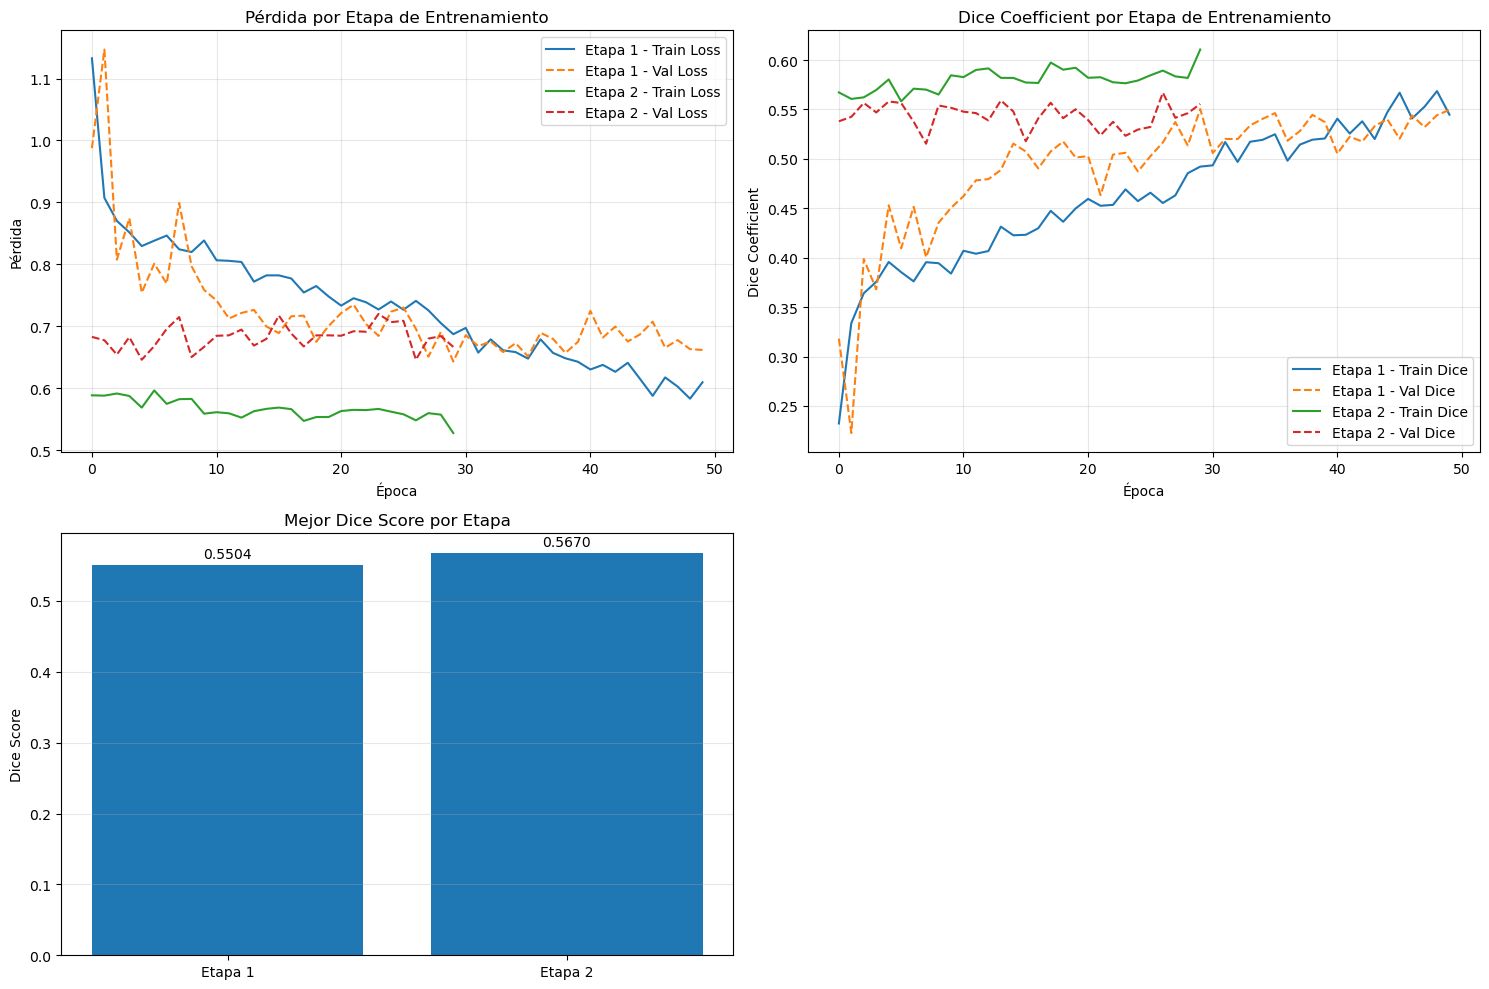


Evaluando modelo tras entrenamiento...
Average Dice Score on test set (threshold=0.2): 0.5960
Modelo con entrenamiento - Dice promedio: 0.5960


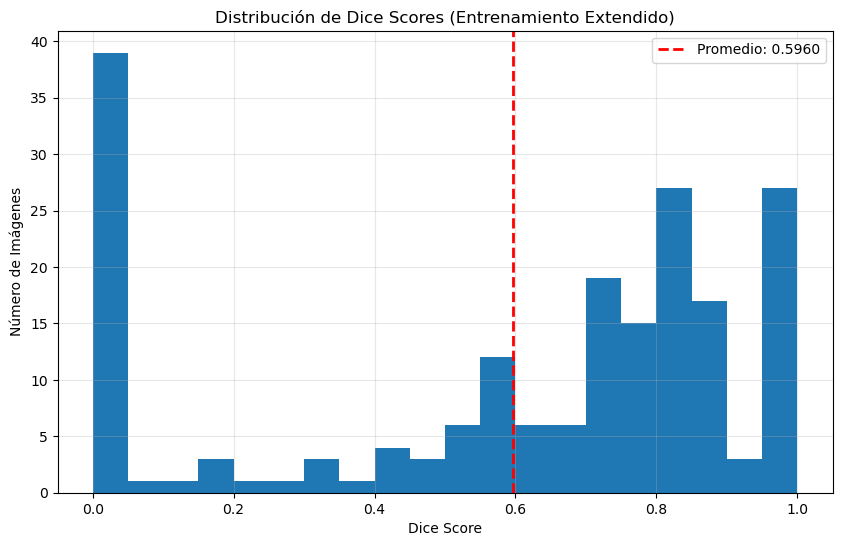


Probando diferentes umbrales con el modelo extendido...

Image index 20:
Dice scores para diferentes umbrales:
 - Umbral 0.1: Dice = 0.5237
 - Umbral 0.2: Dice = 0.4537
 - Umbral 0.3: Dice = 0.3936
 - Umbral 0.4: Dice = 0.3471
Mejor umbral: 0.1 (Dice: 0.5237)


TypeError: Invalid shape (1, 128, 128) for image data

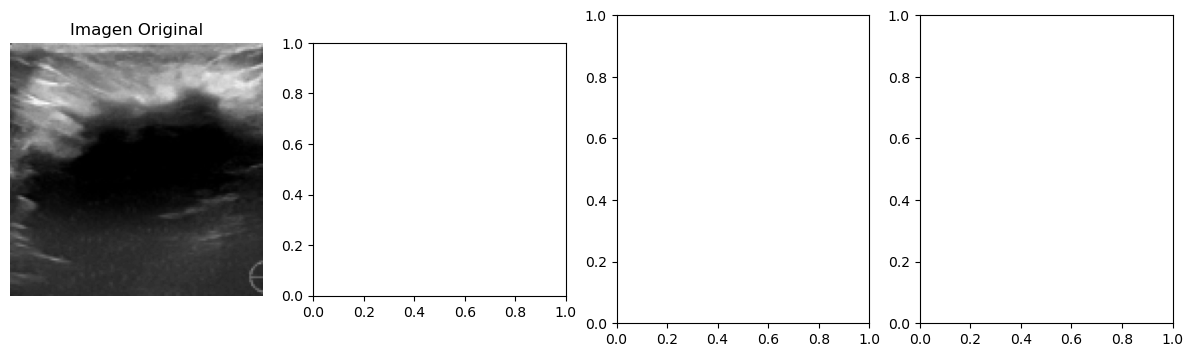

In [61]:
# MAIN EXECUTION - ENTRENAMIENTO 

# Usar los mejores hiperparámetros encontrados por optimización genética
best_hyperparams = [
    0.00046991328373924225,  # Learning rate 
    4.71444689474870e-06,    # Weight decay
    0.07,                    # Dropout 1
    0.32,                    # Dropout 2
    0.41,                    # Dropout 3
    0.24,                    # Dropout 4
    4                        # Batch size
]

# Ejecutar el entrenamiento por etapas
print("\nIniciando entrenamiento por etapas...")
optimized_model, metrics = train_improved_model(
    hyperparams=best_hyperparams,
    total_epochs=100  # 70 épocas etapa 1 + 30 épocas etapa 2
)

# Evaluar el modelo después del entrenamiento
print("\nEvaluando modelo tras entrenamiento...")
test_scores, avg_dice = evaluate_model(optimized_model, test_dataloader, threshold=0.2)
print(f"Modelo con entrenamiento - Dice promedio: {avg_dice:.4f}")

# Visualizar distribución de scores
plt.figure(figsize=(10, 6))
plt.hist(test_scores, bins=20)
plt.axvline(avg_dice, color='r', linestyle='dashed', linewidth=2,
            label=f'Promedio: {avg_dice:.4f}')
plt.title('Distribución de Dice Scores (Entrenamiento Extendido)')
plt.xlabel('Dice Score')
plt.ylabel('Número de Imágenes')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('resultados_entrenamiento_extendido.png', dpi=300)
plt.show()

# Probar umbrales con el modelo extendido
print("\nProbando diferentes umbrales con el modelo extendido...")
threshold_results = test_thresholds(optimized_model, test_dataset, 
                                    indices=[20, 55, 87], 
                                    thresholds=[0.1, 0.2, 0.3, 0.4])

print("\nEntrenamiento extendido completado y evaluado.")


Probando diferentes umbrales con el modelo extendido...

Image index 20:
Dice scores para diferentes umbrales:
 - Umbral 0.1: Dice = 0.5237
 - Umbral 0.2: Dice = 0.4537
 - Umbral 0.3: Dice = 0.3936
 - Umbral 0.4: Dice = 0.3471
Mejor umbral: 0.1 (Dice: 0.5237)


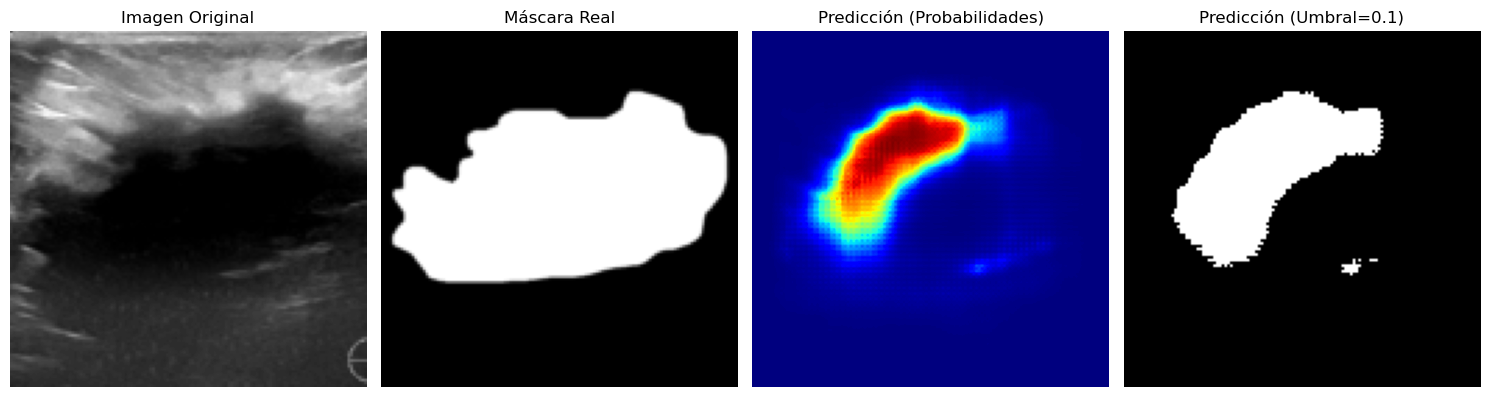

Dice Score: 0.5237

Image index 55:
Dice scores para diferentes umbrales:
 - Umbral 0.1: Dice = 0.0000
 - Umbral 0.2: Dice = 0.0000
 - Umbral 0.3: Dice = 0.0000
 - Umbral 0.4: Dice = 0.0000
Mejor umbral: 0.2 (Dice: 0.0000)


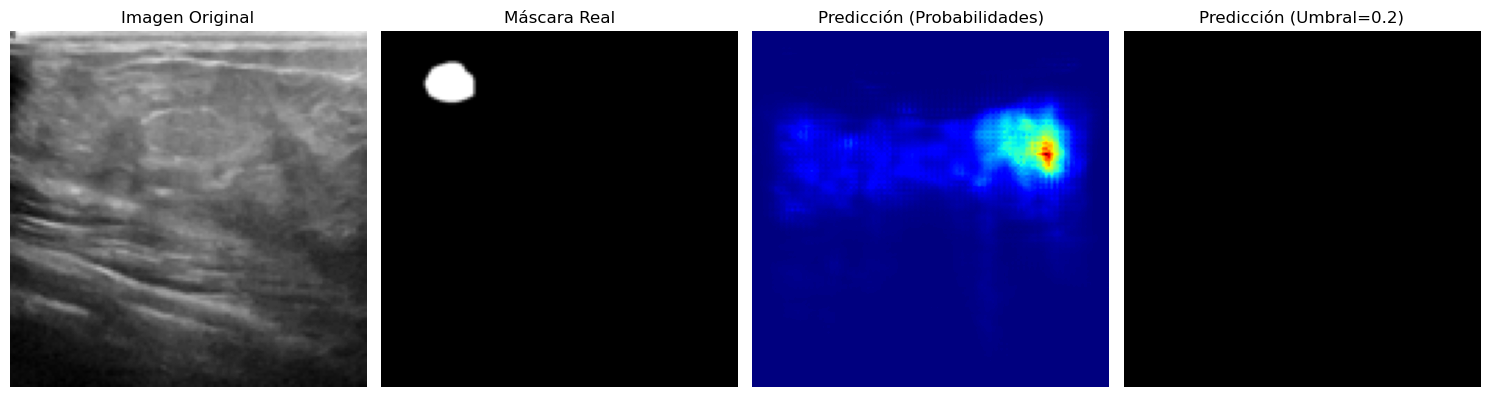

Dice Score: 0.0000

Image index 87:
Dice scores para diferentes umbrales:
 - Umbral 0.1: Dice = 1.0000
 - Umbral 0.2: Dice = 1.0000
 - Umbral 0.3: Dice = 1.0000
 - Umbral 0.4: Dice = 1.0000
Mejor umbral: 0.1 (Dice: 1.0000)


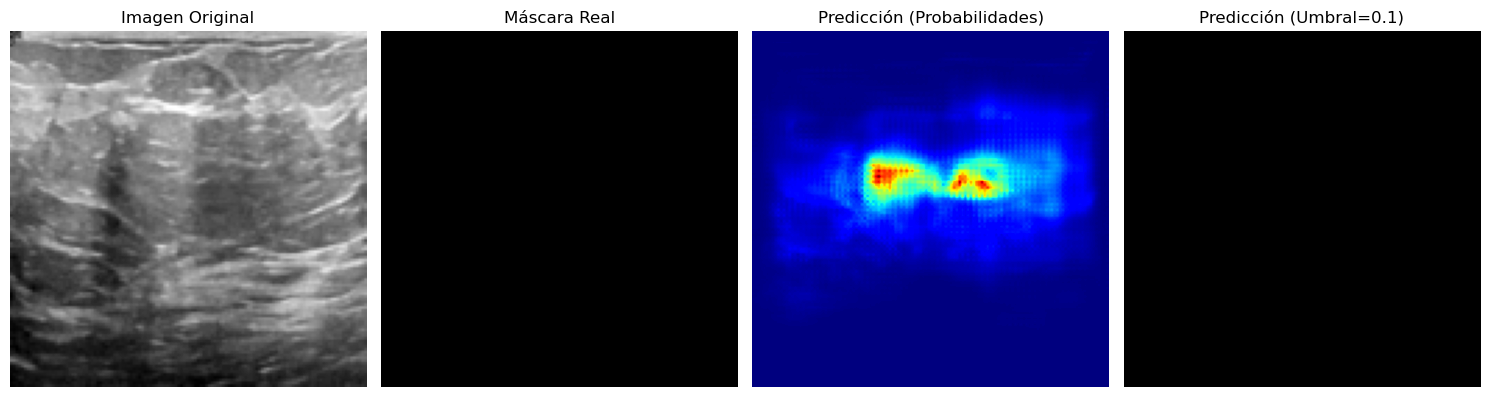

Dice Score: 1.0000

Entrenamiento extendido completado y evaluado.


In [65]:
# Probar umbrales con el modelo extendido
print("\nProbando diferentes umbrales con el modelo extendido...")
threshold_results = test_thresholds(optimized_model, test_dataset, 
                                    indices=[20, 55, 87], 
                                    thresholds=[0.1, 0.2, 0.3, 0.4])

print("\nEntrenamiento extendido completado y evaluado.")